In [ ]:
'''Chatgpt Link:https://chatgpt.com/share/67adc8ce-29a0-8009-82c7-8fc00b7f7688'''

In [1]:
'''    1. Automatic Threshold Selection for Canny Edge Detection 
    • Implement automatic threshold selection using Otsu’s method. 
    • Compute Otsu’s thresholding and apply it to Canny. 
    • Compare results with manually chosen thresholds. Test on images with varying contrast.'''

'    1. Automatic Threshold Selection for Canny Edge Detection \n    • Implement automatic threshold selection using Otsu’s method. \n    • Compute Otsu’s thresholding and apply it to Canny. \n    • Compare results with manually chosen thresholds. Test on images with varying contrast.'

/home/student/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


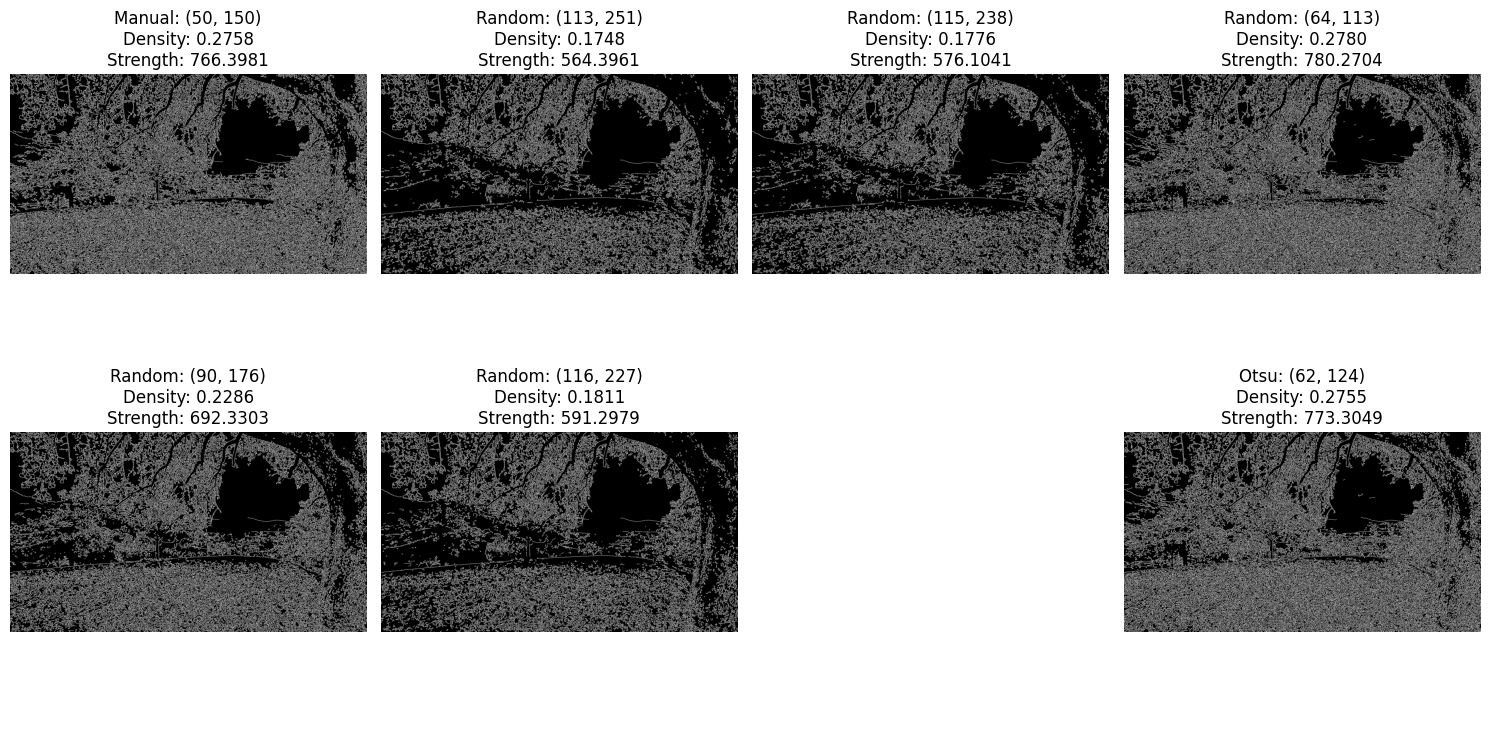


Edge Detection Comparison (Sorted by Edge Strength):
Random 3: Density = 0.2780, Strength = 780.2704
Otsu: Density = 0.2755, Strength = 773.3049
Manual: Density = 0.2758, Strength = 766.3981
Random 4: Density = 0.2286, Strength = 692.3303
Random 5: Density = 0.1811, Strength = 591.2979
Random 2: Density = 0.1776, Strength = 576.1041
Random 1: Density = 0.1748, Strength = 564.3961

Best Edge Detection Method Based on Edge Strength: Random 3


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread(r'/home/student/brightness_adjusted_image.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Canny with a manually chosen threshold
manual_low = 50
manual_high = 150
edges_manual = cv2.Canny(image, manual_low, manual_high)

# Step 2: Select random threshold pairs within intensity range
min_intensity = np.min(image)
max_intensity = np.max(image)
random_thresholds = [(np.random.randint(min_intensity, max_intensity),
                      np.random.randint(min_intensity, max_intensity)) for _ in range(5)]

# Ensure that threshold1 < threshold2
random_thresholds = [(min(low, high), max(low, high)) for low, high in random_thresholds]

# Apply Canny for each random threshold pair
random_edges = [cv2.Canny(image, low, high) for low, high in random_thresholds]

# Step 3: Use Otsu’s method to determine the threshold
otsu_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edges_otsu = cv2.Canny(image, otsu_thresh * 0.5, otsu_thresh)

# Step 4: Compute Edge Density and Edge Strength
def edge_density(edge_image):
    return np.count_nonzero(edge_image) / edge_image.size  # Ratio of edge pixels to total pixels

def edge_strength(edge_image):
    gradient_magnitude = cv2.Sobel(edge_image, cv2.CV_64F, 1, 1, ksize=5)  # Compute Sobel gradient
    return np.mean(np.abs(gradient_magnitude))  # Average gradient magnitude

metrics = {
    "Manual": {"Density": edge_density(edges_manual), "Strength": edge_strength(edges_manual)},
    **{f"Random {i+1}": {"Density": edge_density(edge), "Strength": edge_strength(edge)}
       for i, edge in enumerate(random_edges)},
    "Otsu": {"Density": edge_density(edges_otsu), "Strength": edge_strength(edges_otsu)}
}

# Step 5: Display results
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

axes[0].imshow(edges_manual, cmap='gray')
axes[0].set_title(f"Manual: ({manual_low}, {manual_high})\nDensity: {metrics['Manual']['Density']:.4f}\nStrength: {metrics['Manual']['Strength']:.4f}")

for i, (edge, (low, high)) in enumerate(zip(random_edges, random_thresholds), 1):
    axes[i].imshow(edge, cmap='gray')
    axes[i].set_title(f"Random: ({low}, {high})\nDensity: {metrics[f'Random {i}']['Density']:.4f}\nStrength: {metrics[f'Random {i}']['Strength']:.4f}")

axes[-1].imshow(edges_otsu, cmap='gray')
axes[-1].set_title(f"Otsu: ({otsu_thresh * 0.5:.0f}, {otsu_thresh:.0f})\nDensity: {metrics['Otsu']['Density']:.4f}\nStrength: {metrics['Otsu']['Strength']:.4f}")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Step 6: Print Sorted Comparison
print("\nEdge Detection Comparison (Sorted by Edge Strength):")
sorted_metrics = sorted(metrics.items(), key=lambda x: x[1]["Strength"], reverse=True)
for method, values in sorted_metrics:
    print(f"{method}: Density = {values['Density']:.4f}, Strength = {values['Strength']:.4f}")

# Best Edge Detection Method Based on Edge Strength
best_method = sorted_metrics[0][0]
print(f"\nBest Edge Detection Method Based on Edge Strength: {best_method}")


In [3]:
'''Implement region-growing segmentation by selecting a seed point and expanding based on similarity criteria. Modify region growing to automatically select multiple seeds based on edge detection.'''

'Implement region-growing segmentation by selecting a seed point and expanding based on similarity criteria. Modify region growing to automatically select multiple seeds based on edge detection.'

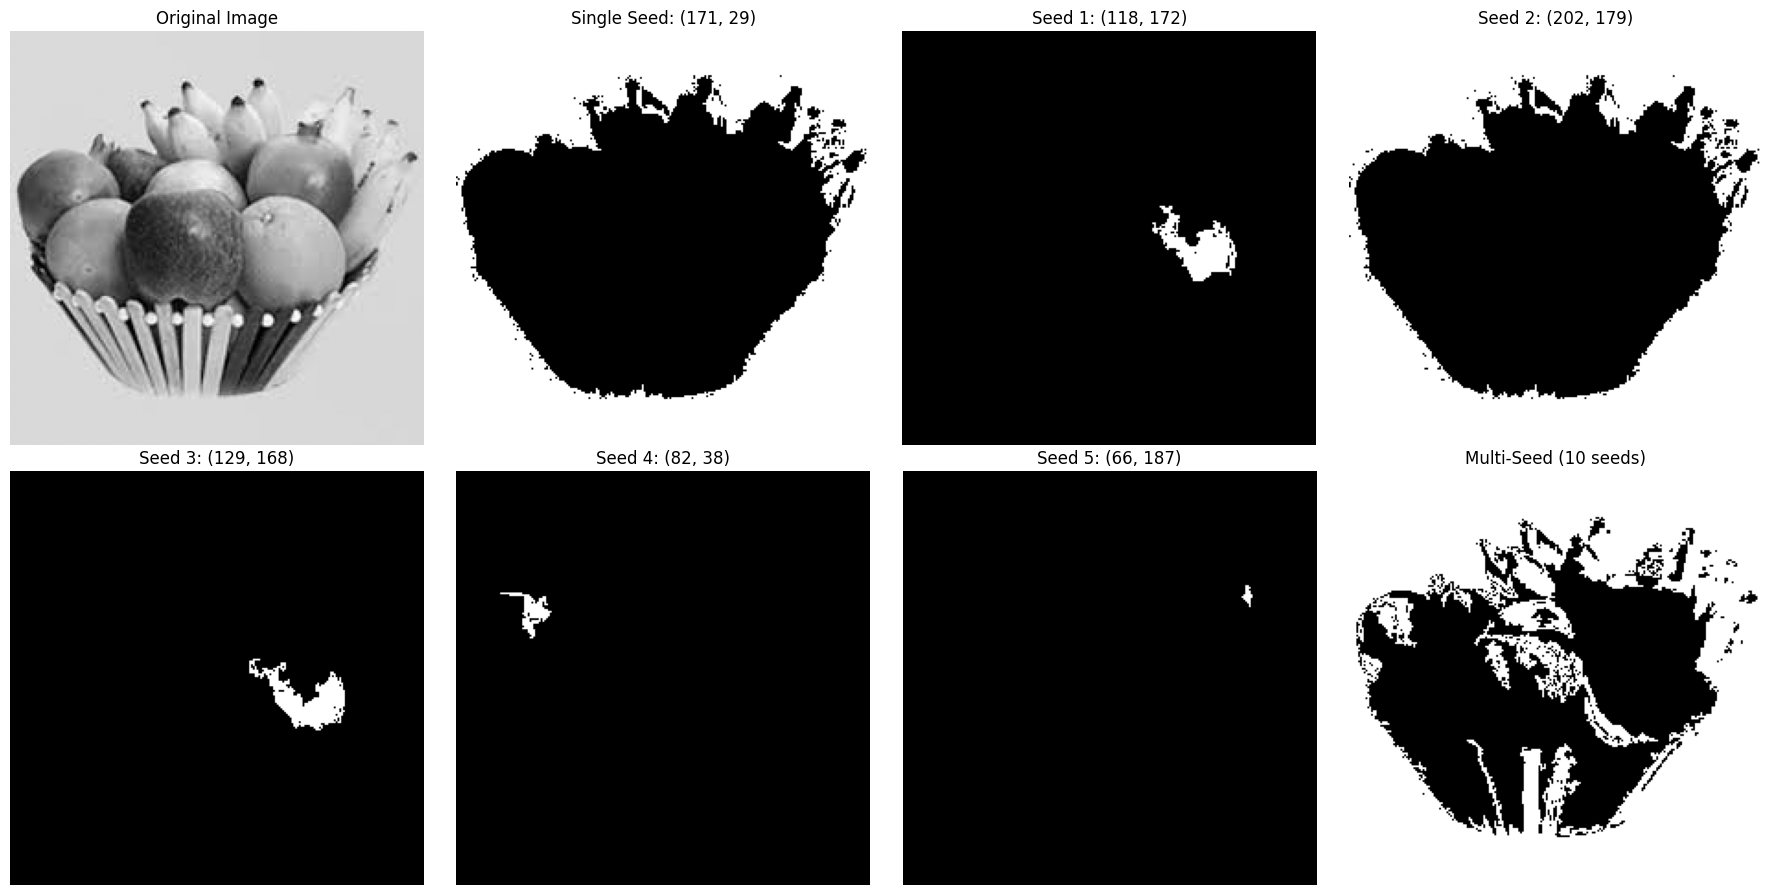


Single Seed: [(171, 29)]
Separate Random Seeds: [(118, 172), (202, 179), (129, 168), (82, 38), (66, 187)]
Multi-Seed Points: [(38, 191), (115, 110), (222, 199), (28, 3), (70, 16), (78, 212), (105, 83), (151, 115), (69, 64), (62, 35)]


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the grayscale image
image = cv2.imread(r'/home/student/Downloads/fruits.jpeg', cv2.IMREAD_GRAYSCALE)

# Function for region-growing segmentation
def region_growing(image, seeds, threshold=10):
    """
    Perform region growing segmentation from a list of seed points.
    """
    segmented = np.zeros_like(image, dtype=np.uint8)  # Output mask
    h, w = image.shape
    visited = np.zeros((h, w), dtype=bool)
    
    # Initialize queue with seed points
    queue = list(seeds)
    
    while queue:
        x, y = queue.pop(0)
        if visited[x, y]:
            continue
        visited[x, y] = True

        # Condition to include pixel in the region
        for sx, sy in seeds:
            if abs(int(image[x, y]) - int(image[sx, sy])) < threshold:
                segmented[x, y] = 255  # Mark as foreground
                
                # Add 4-connected neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                        queue.append((nx, ny))
                break  # Stop checking once one seed's condition is met

    return segmented

# Step 1: Select 1 random seed
h, w = image.shape
random_seed = [(random.randint(0, h-1), random.randint(0, w-1))]

# Apply region growing for the single seed
single_segmentation = region_growing(image, random_seed)

# Step 2: Select 5 random seeds and apply separately
random_seeds = [(random.randint(0, h-1), random.randint(0, w-1)) for _ in range(5)]
separate_segmentations = [region_growing(image, [seed]) for seed in random_seeds]

# Step 3: Select 5-10 random seeds together and perform single segmentation
multi_seed = [(random.randint(0, h-1), random.randint(0, w-1)) for _ in range(10)]
multi_segmentation = region_growing(image, multi_seed)

# Step 4: Display Results
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.ravel()

# Original Image
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Single Seed Segmentation
axes[1].imshow(single_segmentation, cmap="gray")
axes[1].set_title(f"Single Seed: {random_seed[0]}")
axes[1].axis("off")

# Separate Random Seed Segmentations
for i, (seg, seed) in enumerate(zip(separate_segmentations, random_seeds)):
    axes[i+2].imshow(seg, cmap="gray")
    axes[i+2].set_title(f"Seed {i+1}: {seed}")
    axes[i+2].axis("off")

# Multi-seed Segmentation
axes[7].imshow(multi_segmentation, cmap="gray")
axes[7].set_title(f"Multi-Seed (10 seeds)")
axes[7].axis("off")

plt.tight_layout()
plt.show()

# Step 5: Print Seed Points
print("\nSingle Seed:", random_seed)
print("Separate Random Seeds:", random_seeds)
print("Multi-Seed Points:", multi_seed)


In [5]:
'''Implement a quadtree-based region split and merge method for segmenting an image. Modify region splitting based on texture features (entropy, variance, Laplacian) instead of pixel intensity alone.'''

'Implement a quadtree-based region split and merge method for segmenting an image. Modify region splitting based on texture features (entropy, variance, Laplacian) instead of pixel intensity alone.'

Number of splits (homogeneous blocks):
Intensity-based: 4081
Laplacian-based: 3976
Entropy-based  : 4051
Variance-based : 3793


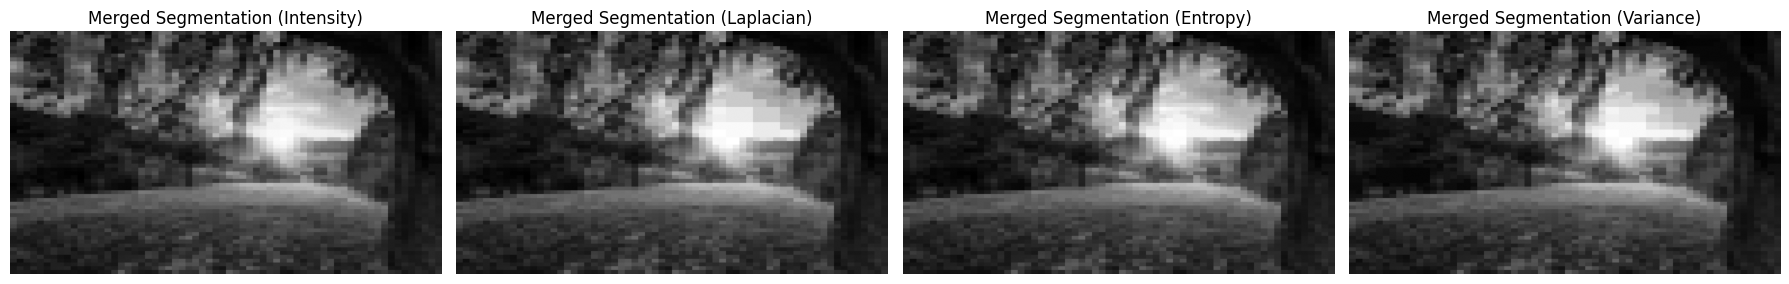

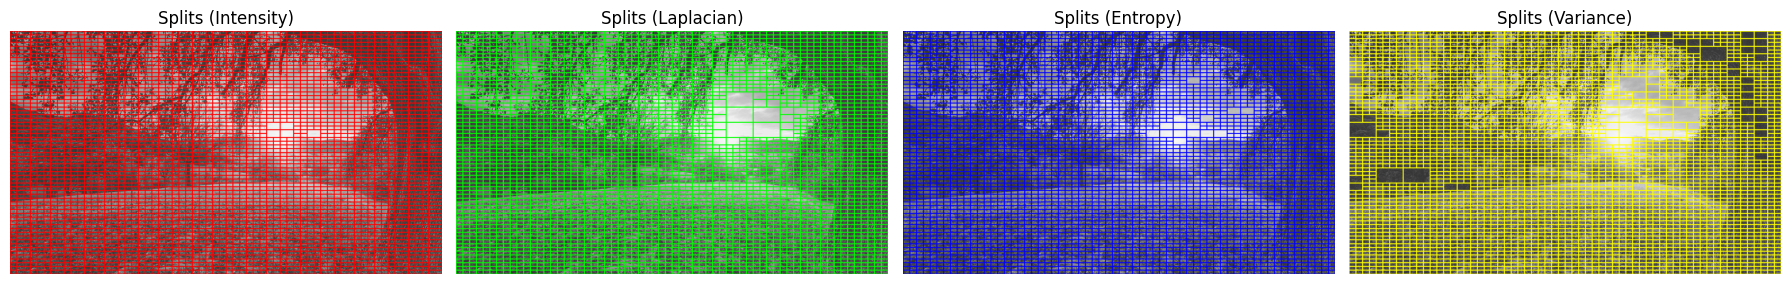

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_entropy(region):
    """
    Compute the entropy of a grayscale image region.
    """
    hist, _ = np.histogram(region, bins=256, range=(0,256), density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def quadtree_segmentation_with_splits(img, x, y, width, height, criterion, thresholds, min_size):
    """
    Recursively splits the image region into quadrants.
    Uses a homogeneity test based on the given criterion.
    
    Parameters:
      img        : Grayscale image.
      x, y       : Top-left coordinates of the region.
      width      : Width of the region.
      height     : Height of the region.
      criterion  : One of "intensity", "laplacian", "entropy", "variance".
      thresholds : Dictionary containing the threshold value for the chosen criterion.
                   For "intensity": {'intensity': value}
                   For "laplacian": {'laplacian': value}
                   For "entropy":   {'entropy': value}
                   For "variance":  {'variance': value}
      min_size   : Minimum region size to stop splitting.
    
    Returns:
      seg    : The merged segmented region (a 2D array) after merging homogeneous regions.
      splits : A list of homogeneous block boundaries as tuples (x, y, width, height).
    """
    region = img[y:y+height, x:x+width]
    
    # If the region is too small, stop splitting.
    if width <= min_size or height <= min_size:
        mean_val = np.mean(region)
        seg = np.full((height, width), mean_val, dtype=np.uint8)
        splits = [(x, y, width, height)]
        return seg, splits
    
    homogeneous = False
    if criterion == 'intensity':
        # Use intensity range (max-min)
        if (np.max(region) - np.min(region)) < thresholds['intensity']:
            homogeneous = True
    elif criterion == 'laplacian':
        lap_var = np.var(cv2.Laplacian(region, cv2.CV_64F))
        if lap_var < thresholds['laplacian']:
            homogeneous = True
    elif criterion == 'entropy':
        ent = compute_entropy(region)
        if ent < thresholds['entropy']:
            homogeneous = True
    elif criterion == 'variance':
        var_val = np.var(region)
        if var_val < thresholds['variance']:
            homogeneous = True
    else:
        raise ValueError("Unknown criterion")
    
    if homogeneous:
        mean_val = np.mean(region)
        seg = np.full((height, width), mean_val, dtype=np.uint8)
        splits = [(x, y, width, height)]
        return seg, splits
    else:
        # Split the region into 4 quadrants.
        half_w = width // 2
        half_h = height // 2
        
        seg_tl, splits_tl = quadtree_segmentation_with_splits(img, x, y, half_w, half_h, criterion, thresholds, min_size)
        seg_tr, splits_tr = quadtree_segmentation_with_splits(img, x+half_w, y, width-half_w, half_h, criterion, thresholds, min_size)
        seg_bl, splits_bl = quadtree_segmentation_with_splits(img, x, y+half_h, half_w, height-half_h, criterion, thresholds, min_size)
        seg_br, splits_br = quadtree_segmentation_with_splits(img, x+half_w, y+half_h, width-half_w, height-half_h, criterion, thresholds, min_size)
        
        top = np.hstack((seg_tl, seg_tr))
        bottom = np.hstack((seg_bl, seg_br))
        seg = np.vstack((top, bottom))
        
        splits = splits_tl + splits_tr + splits_bl + splits_br
        return seg, splits

def draw_splits(img, splits, color=(0, 255, 0), thickness=2):
    """
    Draw rectangles for each split (homogeneous block) on a color copy of the image.
    
    Parameters:
      img       : Grayscale image.
      splits    : List of (x, y, width, height) tuples.
      color     : Rectangle color (B, G, R).
      thickness : Thickness of rectangle borders.
      
    Returns:
      img_copy  : Image with rectangles drawn.
    """
    img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (x, y, w_box, h_box) in splits:
        cv2.rectangle(img_copy, (x, y), (x+w_box, y+h_box), color, thickness)
    return img_copy

# ---------------------------
# Main Execution
# ---------------------------
# Load the input image (grayscale)
image_path = r'/home/student/brightness_adjusted_image.jpg' # Replace with your image file path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise IOError("Image not found. Please check the image path.")
h, w = img.shape

min_size = 16  # Minimum region size

# Define thresholds for each criterion (tune as needed)
thresholds_intensity = {'intensity': 20.0}     # intensity range threshold
thresholds_laplacian = {'laplacian': 50.0}       # Laplacian variance threshold
thresholds_entropy   = {'entropy': 4.0}          # Entropy threshold
thresholds_variance  = {'variance': 100.0}         # Variance threshold

# Run quadtree segmentation for each criterion.
seg_intensity, splits_intensity = quadtree_segmentation_with_splits(img, 0, 0, w, h, 'intensity', thresholds_intensity, min_size)
seg_laplacian, splits_laplacian = quadtree_segmentation_with_splits(img, 0, 0, w, h, 'laplacian', thresholds_laplacian, min_size)
seg_entropy, splits_entropy = quadtree_segmentation_with_splits(img, 0, 0, w, h, 'entropy', thresholds_entropy, min_size)
seg_variance, splits_variance = quadtree_segmentation_with_splits(img, 0, 0, w, h, 'variance', thresholds_variance, min_size)

# Draw the splits (boundaries) on the original image.
img_splits_intensity = draw_splits(img, splits_intensity, color=(255, 0, 0), thickness=2)
img_splits_laplacian = draw_splits(img, splits_laplacian, color=(0, 255, 0), thickness=2)
img_splits_entropy   = draw_splits(img, splits_entropy,   color=(0, 0, 255), thickness=2)
img_splits_variance  = draw_splits(img, splits_variance,  color=(255, 255, 0), thickness=2)

# Print the number of splits for each method.
print("Number of splits (homogeneous blocks):")
print("Intensity-based:", len(splits_intensity))
print("Laplacian-based:", len(splits_laplacian))
print("Entropy-based  :", len(splits_entropy))
print("Variance-based :", len(splits_variance))

# ---------------------------
# Visualization
# ---------------------------
# Display merged segmentation results.
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(seg_intensity, cmap='gray')
plt.title("Merged Segmentation (Intensity)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(seg_laplacian, cmap='gray')
plt.title("Merged Segmentation (Laplacian)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(seg_entropy, cmap='gray')
plt.title("Merged Segmentation (Entropy)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(seg_variance, cmap='gray')
plt.title("Merged Segmentation (Variance)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Display splits (boundaries) over the original image.
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_splits_intensity)
plt.title("Splits (Intensity)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_splits_laplacian)
plt.title("Splits (Laplacian)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_splits_entropy)
plt.title("Splits (Entropy)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_splits_variance)
plt.title("Splits (Variance)")
plt.axis('off')

plt.tight_layout()
plt.show()


Graphviz layout not available; using spring_layout instead. No module named 'pydot'


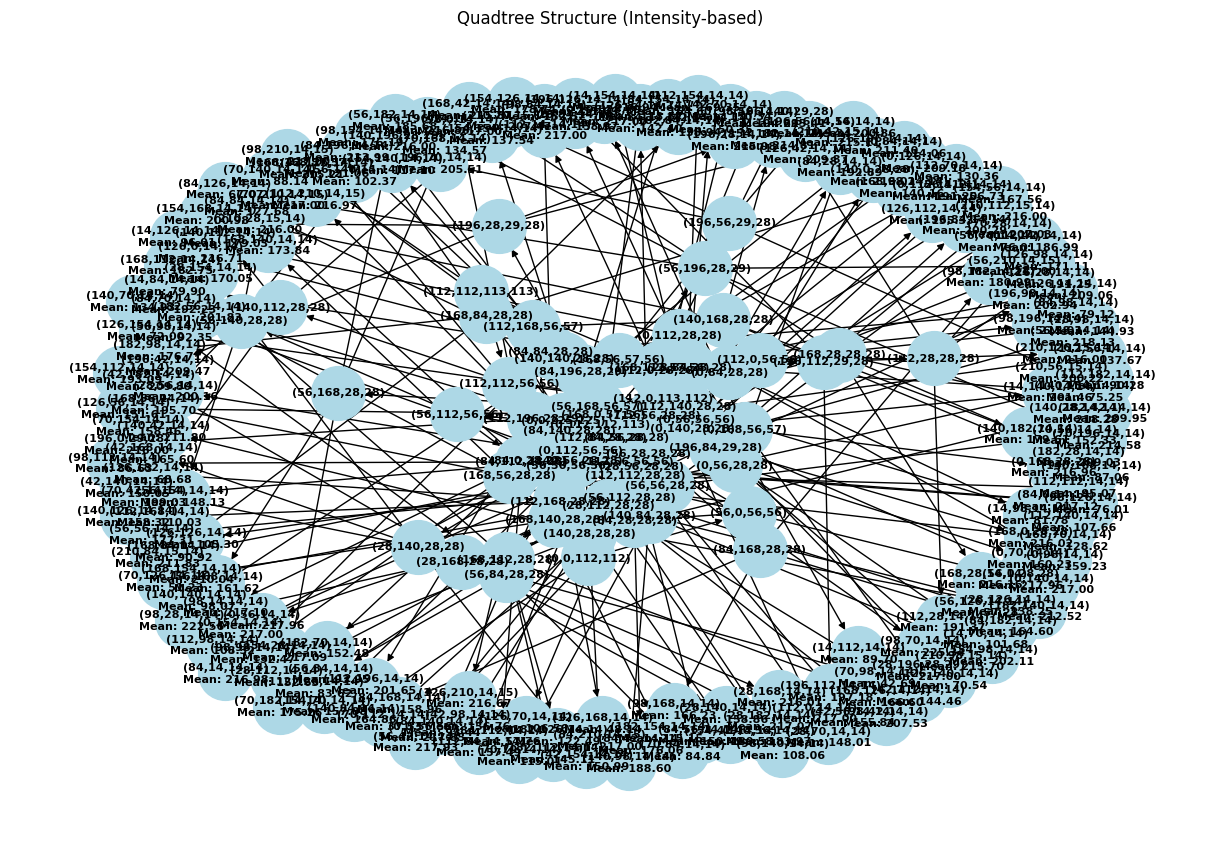

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def compute_entropy(region):
    hist, _ = np.histogram(region, bins=256, range=(0,256), density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def build_quadtree(img, x, y, width, height, criterion, thresholds, min_size):
    region = img[y:y+height, x:x+width]
    if width <= min_size or height <= min_size:
        mean_val = np.mean(region)
        return {"x": x, "y": y, "width": width, "height": height,
                "homogeneous": True, "mean": mean_val, "children": []}
    homogeneous = False
    if criterion == 'intensity':
        if (np.max(region) - np.min(region)) < thresholds['intensity']:
            homogeneous = True
    elif criterion == 'laplacian':
        lap_var = np.var(cv2.Laplacian(region, cv2.CV_64F))
        if lap_var < thresholds['laplacian']:
            homogeneous = True
    elif criterion == 'entropy':
        ent = compute_entropy(region)
        if ent < thresholds['entropy']:
            homogeneous = True
    elif criterion == 'variance':
        var_val = np.var(region)
        if var_val < thresholds['variance']:
            homogeneous = True
    if homogeneous:
        mean_val = np.mean(region)
        return {"x": x, "y": y, "width": width, "height": height,
                "homogeneous": True, "mean": mean_val, "children": []}
    else:
        half_w = width // 2
        half_h = height // 2
        child_tl = build_quadtree(img, x, y, half_w, half_h, criterion, thresholds, min_size)
        child_tr = build_quadtree(img, x+half_w, y, width-half_w, half_h, criterion, thresholds, min_size)
        child_bl = build_quadtree(img, x, y+half_h, half_w, height-half_h, criterion, thresholds, min_size)
        child_br = build_quadtree(img, x+half_w, y+half_h, width-half_w, height-half_h, criterion, thresholds, min_size)
        return {
            "x": x, "y": y, "width": width, "height": height,
            "homogeneous": False,
            "children": [child_tl, child_tr, child_bl, child_br]
        }

def build_quadtree_graph(tree):
    G = nx.DiGraph()
    counter = [0]
    def add_nodes(node, parent=None):
        current_id = counter[0]
        counter[0] += 1
        label = f"({node['x']},{node['y']},{node['width']},{node['height']})"
        if node.get("homogeneous", False):
            label += f"\nMean: {node.get('mean',0):.2f}"
        G.add_node(current_id, label=label)
        if parent is not None:
            G.add_edge(parent, current_id)
        for child in node.get("children", []):
            add_nodes(child, current_id)
    add_nodes(tree)
    return G

def draw_quadtree_graph(G):
    try:
        # Try to use pydot-based graphviz layout
        pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    except Exception as e:
        print("Graphviz layout not available; using spring_layout instead.", e)
        pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=1500,
            node_color="lightblue", font_size=8, font_weight="bold", arrows=True)
    plt.title("Quadtree Structure (Intensity-based)")
    plt.axis("off")
    plt.show()

# Main Execution
image_path = '/home/student/Downloads/fruits.jpeg'# Replace with your image file path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise IOError("Image not found. Please check the image path.")
h, w = img.shape

min_size = 16
thresholds_intensity = {'intensity': 20.0}

# Build quadtree based on intensity
quadtree = build_quadtree(img, 0, 0, w, h, 'intensity', thresholds_intensity, min_size)
G = build_quadtree_graph(quadtree)
draw_quadtree_graph(G)
